In [1]:
from __future__ import absolute_import, division, print_function

from tensorflow import keras
from tensorflow.keras import layers
import bisect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
import tensorflow as tf

In [46]:
def read_data(dates):
    t = []
    for date in dates:
        tmp = pd.read_csv('/Users/felipe/bitcoin/data/{}-training.csv'.format(str(date)),
                          index_col='time',
                          parse_dates=True)
        t.append(tmp)
    return pd.concat(t)

In [47]:
t = read_data([20190520, 20190521])

In [51]:
t.columns

Index(['longPnlAvg', 'shortPnlAvg', 'boughtSum', 'soldSum', 'bidPriceAvg',
       'askPriceAvg', 'bidSizeAvg', 'askSizeAvg', 'spreadAvg'],
      dtype='object')

In [29]:
train_dataset = t.sample(frac=0.8,random_state=0)
test_dataset = t.drop(train_dataset.index)
train_stats = train_dataset.describe().transpose()
del t

In [30]:
x_cols = [i for i in train_dataset.columns if i not in ('longPnlAvg', 'shortPnlAvg')]
y_cols = ['longPnlAvg', 'shortPnlAvg']

train_labels = train_dataset[y_cols]
test_labels = test_dataset[y_cols]
train_dataset = train_dataset[x_cols]
test_dataset = test_dataset[x_cols]

In [31]:
def norm(xx):
    x = xx.copy()
    for c in x.columns:
        x[c] -= train_stats['mean'][c]
        x[c] /= train_stats['std'][c]
    return x

In [32]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [51]:
def build_model():
    model = keras.Sequential([
        #layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        #layers.Dense(64, activation=tf.nn.relu),
        #layers.Dense(2)
        layers.Dense(2, input_shape=[len(train_dataset.keys())])
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
            optimizer=optimizer,
            metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 100       
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________


In [53]:
# sns.pairplot(train_dataset[['longPnlAvg', 'E2boughtSum', 'E2soldSum']], diag_kind="kde")

In [54]:
# test
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-3.3640780e+00,  7.2535133e-01],
       [-1.8880553e+00, -1.4785385e-01],
       [ 2.6140866e+00, -5.9923881e-01],
       [ 2.9599340e+00, -1.3846033e+00],
       [-1.9504996e-03, -2.8883567e-01],
       [ 1.7633506e+00, -1.5136794e+00],
       [-6.6137528e-01, -5.7026852e-02],
       [ 2.4765110e+00, -8.5831612e-01],
       [ 9.6234155e-01, -3.0977446e-01],
       [ 5.2407843e-01, -1.4917796e+00]], dtype=float32)

In [55]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

....................................................................................................20%
....................................................................................................40%
....................................................................................................60%
.................................................................

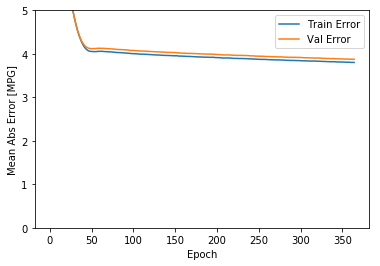

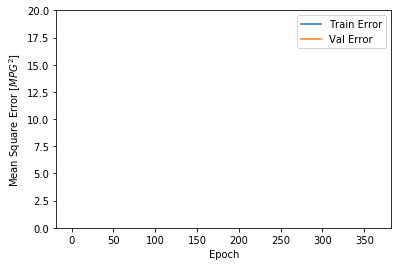

In [56]:
# Display training progress by printing a single dot for each completed epoch
EPOCHS = 500

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0 and epoch > 0: print('{}%'.format(int(epoch*100/EPOCHS)))
        print('.', end='')
        
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    normed_train_data, train_labels,
    epochs=1000,
    validation_split = 0.2,
    verbose=0,
    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [57]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
360,28.871658,3.804974,28.871655,29.324542,3.876092,29.324543,360
361,28.867584,3.802163,28.867584,29.317340,3.876479,29.317341,361
362,28.850018,3.804214,28.850010,29.337546,3.875551,29.337542,362
363,28.840884,3.803473,28.840885,29.323044,3.874372,29.323044,363
364,28.829051,3.801877,28.829048,29.303933,3.874685,29.303936,364


In [59]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} PNL".format(mae))

Testing set Mean Abs Error:  3.81 PNL


In [72]:
test_labels.as_matrix().flatten()

array([-0.63846154,  0.87307692, -0.36206897, ...,  3.        ,
        5.        ,  2.74705882])

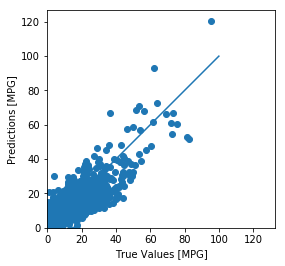

In [73]:
test_predictions = model.predict(normed_test_data)

plt.scatter(test_labels.as_matrix().flatten(), test_predictions.flatten())
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

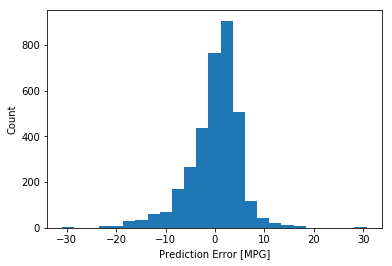

In [79]:
error = test_predictions.flatten() - test_labels.as_matrix().flatten()
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [87]:
max(error), min(error)

(30.66749202843868, -30.870521545410156)

In [82]:
sign_error = test_predictions.flatten() * test_labels.as_matrix().flatten()

In [86]:
sum(sign_error < 0) / len(sign_error)

0.12760416666666666

In [88]:
tf.trainable_variables()

[<tf.Variable 'dense/kernel:0' shape=(49, 2) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32>,
 <tf.Variable 'RMSprop/lr:0' shape=() dtype=float32>,
 <tf.Variable 'RMSprop/rho:0' shape=() dtype=float32>,
 <tf.Variable 'RMSprop/decay:0' shape=() dtype=float32>,
 <tf.Variable 'RMSprop/iterations:0' shape=() dtype=int64>,
 <tf.Variable 'dense_1/kernel:0' shape=(49, 2) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32>,
 <tf.Variable 'RMSprop_1/lr:0' shape=() dtype=float32>,
 <tf.Variable 'RMSprop_1/rho:0' shape=() dtype=float32>,
 <tf.Variable 'RMSprop_1/decay:0' shape=() dtype=float32>,
 <tf.Variable 'RMSprop_1/iterations:0' shape=() dtype=int64>,
 <tf.Variable 'training/RMSprop/Variable:0' shape=(49, 2) dtype=float32>,
 <tf.Variable 'training/RMSprop/Variable_1:0' shape=(2,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(49, 2) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(2,) dtype=float32>,
 <tf.Variable 'RMSprop_2/lr:0' sha

In [90]:
var = [v for v in tf.trainable_variables() if v.name.startswith("dense_3")][0]

In [125]:
pd.DataFrame(model.get_weights()[0])\
.set_index(test_dataset.keys())\
.rename(columns={0: 'buyPnl', 1: 'sellPnl'})\
.sort_values(by='buyPnl')

,buyPnl,sellPnl
E60soldSum,-2.858211,-0.857166
bidPriceAvg,-2.322055,2.406816
askPriceAvg,-2.104322,2.139055
E2askPriceAvg,-1.623266,1.941769
E2bidPriceAvg,-1.621060,1.932353
E3askPriceAvg,-1.422690,1.408711
E6spreadAvg,-1.409747,-0.803006
E15boughtSum,-1.321506,4.287886
E30bidSizeAvg,-1.288543,-0.718810
E3bidPriceAvg,-1.222031,1.620211
